<a href="https://colab.research.google.com/github/nikxlvii/pytorch/blob/main/diff_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
# importing the dataset
cif10 = datasets.CIFAR10(root = './data', train = True, download = True)

100%|██████████| 170498071/170498071 [00:01<00:00, 98116850.64it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# creating a convolution

conv = nn.Conv2d(3,16,kernel_size = 3, padding = 1)
conv,conv.weight.shape,conv.bias.shape

# setting the bias to zero

with torch.no_grad():
  conv.bias.zero_()

# setting the weight to 1/9, we could've just put one that would result in each pixel in the output being the sum of the pixels in the neighbourhood

with torch.no_grad():
  conv.weight.fill_(1.0/9.0)

For now, we will convert an individual image from the CIFAR10 dataset to a tensor.

In [6]:
img, _ = cif10[0]
img.size, type(img)

((32, 32), PIL.Image.Image)

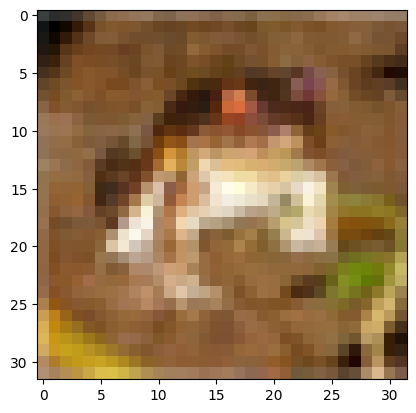

In [7]:
plt.imshow(img)
plt.show()

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [9]:
# applying the convolution and getting the output

output = conv(img_t.unsqueeze(0))
img_t.unsqueeze(0), output.shape

(tensor([[[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
           [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
           [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
           ...,
           [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
           [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
           [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
          [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
           [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
           [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
           ...,
           [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
           [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
           [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
          [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
           [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
           [0.0824, 0.00

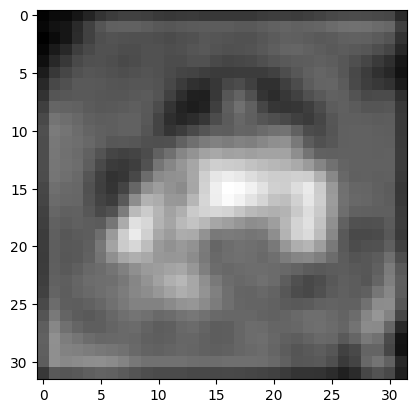

In [10]:
plt.imshow(output[0,0].detach(), cmap = 'gray')
plt.show()

This filter produces a blurred version of the image. Every pixel of the output is the average of a neighbourhood of the input, so pixels in the output are correlated and change more smoothly.

Now let's try a different kernel

In [11]:
conv1 = nn.Conv2d(3,1,kernel_size=3,padding=1)

In [12]:
with torch.no_grad():
  # establishing the weight (kernel)
  conv1.weight[:] = torch.tensor([[-1.0,0.0,1.0],
                                  [-1.0,0.0,1.0],
                                  [-1.0,0.0,1.0]])

  conv1.bias.zero_()

In [13]:
output_1 = conv1(img_t.unsqueeze(0))
output_1.shape

torch.Size([1, 1, 32, 32])

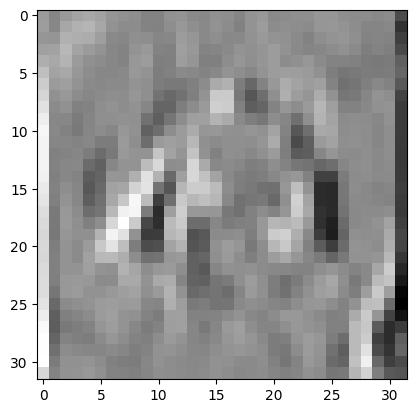

In [14]:
plt.imshow(output_1[0,0].detach(), cmap='gray')
plt.show()

It’s an edge-detection kernel: the kernel highlights the
vertical edge between two horizontally adjacent regions.

We can make our own nn.Module subclasses that we can just use like prebuilt ones or nn.Sequential. This gives us added flexibility. We define a forward funciton which can define our module's computation. To include submodules, we define them in the constructor __init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call super().__init__() before you can do that (or PyTorch will remind you)

In [15]:
# defining our own subclass

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding =1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8*8*8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)


  def forward(self,x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*8)
    out = self.act3(self.fc1(out))
    out = self.fc2(out)

    return out

In [16]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

It is bit of a waste when we register submodules like Tanh() which don't have any input parameters. We can directly call them in the forward function.

For this, Pytorch has a functional counterpart which solely depends on the value input arguments. Hence we can re-write the subclass again.

In [17]:
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
    self.fc1 = nn.Linear(8*8*8,32)
    self.fc2 = nn.Linear(32,2)

  def forward(self,x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
    out = out.view(-1,8*8*8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)

    return out

In [19]:
model = Net()
model(img_t.unsqueeze(0))

tensor([[-0.1373, -0.1901]], grad_fn=<AddmmBackward0>)